In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [20]:
def interpretData(data_list, thickness_info = True, thickness_list = None):
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000

    #retrieve thickness data
    thickness = []
    if thickness_info:
        thickness = thickness_list
    else:
        for i in range(len(data_list)):
            thickness.append(-data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > 2].iloc[0])
    print("Thickness:", thickness)

    mechanicalProperties = []
    
    #SET UP STRESS STRAIN CURVE
    for i in range(len(data_list)): 
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000     #convert in to um
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10      #create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]      #create strain column which is displacement / thickness, the thickness is shown above
    plt.figure(figsize=(8, 6))
    
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        data = data_list[i][data_list[i]['Ch:Load (N)'] >1]      
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)     #resets indexing
        fracture_index = data['stress (bar)'].idxmax()     #find index of fracture point
        fracture_index += 1
        data = data.iloc[:fracture_index]     #remove datapoints after fracture point

        plt.scatter(data['strain'], data['stress (bar)'], color='lightgrey', label=data_name)

    #SPLINE MODEL
        gam = LinearGAM(s(0))
        gam.fit(data[['strain']], data['stress (bar)'])
        predictions = gam.predict(data[['strain']])
        #print(gam.summary())
        plt.plot(data[['strain']], predictions, color='black',label='Spline Model')

    #DERIVATIVE
        data['1st derivative'] = np.gradient(predictions, data['strain'])
        data['2nd derivative'] = np.gradient(data['1st derivative'], data['strain'])

    #SEGMENT REGIONS
        #elastic region
        data['2nd derivative'].idxmin()
        breakpoint1 = data['strain'][data['2nd derivative'].idxmin()]
        #yieldStrength = data['stress (bar)'][data['2nd derivative'].idxmin()]
        #plt.scatter(changepoint1, yieldStrength, color='black', label='Change Point 1')
        elasticRegion = data[data['strain'] <= breakpoint1]
        
        modelElastic = LinearRegression()
        modelElastic.fit(elasticRegion['strain'].values.reshape(-1, 1), elasticRegion['stress (bar)'].values)
        elasticModulus = modelElastic.coef_[0]
        yieldStrength = modelElastic.predict(breakpoint1.reshape(1,-1))
        predElastic = modelElastic.predict(elasticRegion[['strain']])

        #plateau & densification region
        regions = data[data['strain'] >= breakpoint1]
        pw_fit = piecewise_regression.Fit(list(regions['strain']), list(regions['stress (bar)']), n_breakpoints=6)
        pw_results = pw_fit.get_results()
        breakpoint2 = pw_results['estimates']['breakpoint1']['estimate']
        breakpoint3 = pw_results['estimates']['breakpoint6']['estimate']
        plateauRegion = regions[regions['strain'] <= breakpoint2]
        densificationRegion = regions[regions['strain'] >= breakpoint3]

        #plateau region
        modelPlateau = LinearRegression()
        modelPlateau.fit(plateauRegion['strain'].values.reshape(-1, 1), plateauRegion['stress (bar)'].values)
        slopePlateau = modelPlateau.coef_[0]
        interceptPlateau = modelPlateau.intercept_

        #densification region
        modelDensification = LinearRegression()
        modelDensification.fit(densificationRegion['strain'].values.reshape(-1, 1), densificationRegion['stress (bar)'].values)
        slopeDensification = modelDensification.coef_[0]
        interceptDensification = modelDensification.intercept_

        #changepoint calculations
        changepoint = (interceptDensification - interceptPlateau) / (slopePlateau - slopeDensification)
        xPlateau = data[(breakpoint1 <= data['strain']) & (data['strain'] <= changepoint)]
        xDensification = data[changepoint <= data['strain']]
        predPlateau = modelPlateau.predict(xPlateau[['strain']])
        predDensification = modelDensification.predict(xDensification[['strain']])

    #MATERIAL PROPERTIES
        dict = {"Elastic Modulus":elasticModulus, "Yield Strength":yieldStrength, "Changepoint":changepoint, "Slope Plateau":slopePlateau}
        mechanicalProperties.append(dict)

    #FINAL GRAPH
        plt.plot(elasticRegion['strain'], predElastic, color='blue',  label='Elastic Region')
        plt.plot(xPlateau['strain'], predPlateau, color='orange', label="Plateau Region")
        plt.plot(xDensification['strain'], predDensification, color='green', label="Densification Region")
        plt.title(data_name)
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

    #DERIVATIVE PLOT
        #plt.plot(data[['strain']], data['2nd derivative'], label='2nd Derivative')
        #plt.title('2nd Derivative')
        #plt.xlabel('Strain')
        #plt.ylabel('Stress (bar)')
        #plt.legend(loc='upper left')
        #plt.show()

Thickness: [94.615, 91.44, 94.9452, 92.76079999999999]


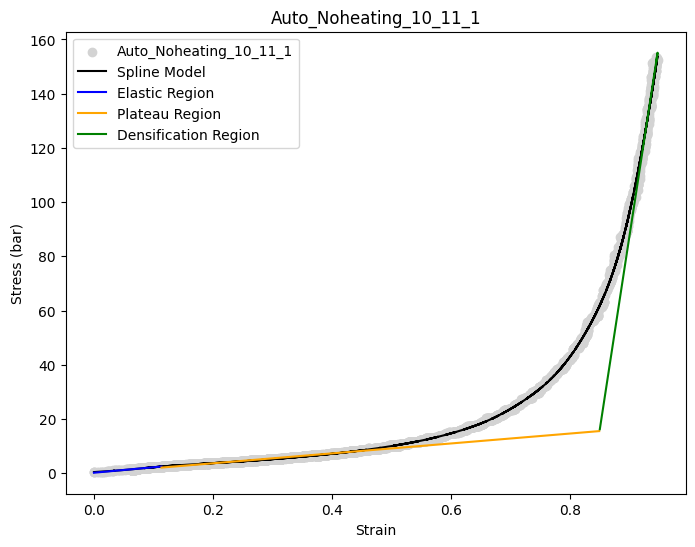

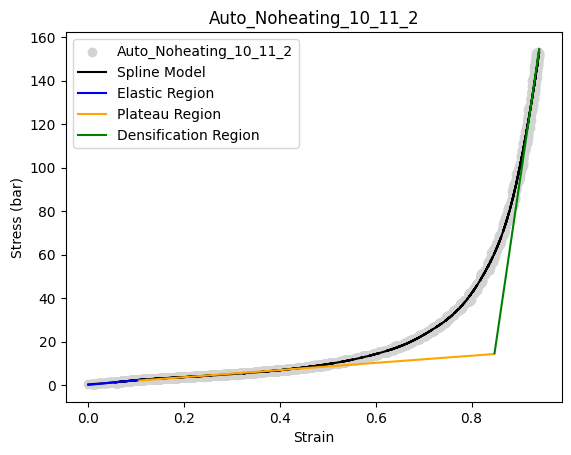

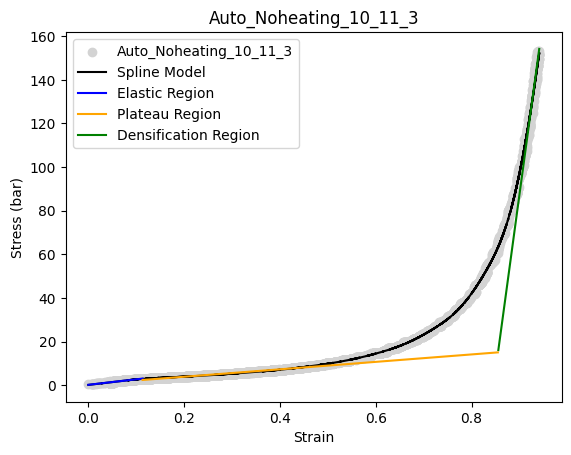

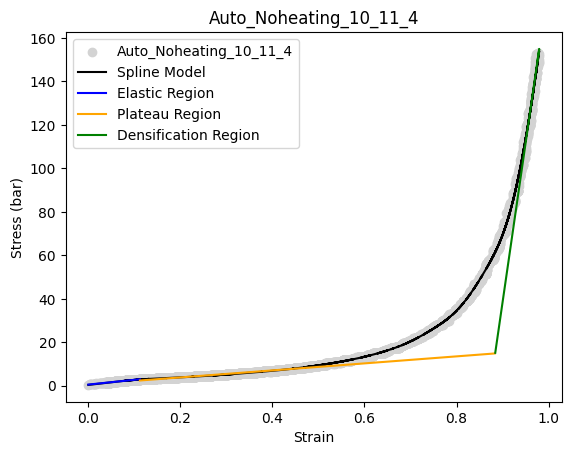

In [21]:
Auto_Noheating_10_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-1-240529_05292024_155944.csv')
Auto_Noheating_10_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-2-240529_05292024_160237.csv')
Auto_Noheating_10_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-3-240529_05292024_160529.csv')
Auto_Noheating_10_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-4-240529_05292024_160857.csv')

data_list = [Auto_Noheating_10_11_1, Auto_Noheating_10_11_2, Auto_Noheating_10_11_3, Auto_Noheating_10_11_4]
interpretData(data_list, thickness_info = False)